<a href="https://colab.research.google.com/github/AKSHYATA15/SIH-PROJECT/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
from transformers import YolosFeatureExtractor, YolosForObjectDetection
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage

In [2]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount='True')

Mounted at /content/gdrive


In [3]:
# Here you should put the path of your image
IMAGE_PATH = "/content/gdrive/MyDrive/SIH-PROJECT/1/IMAGE-SET-2/70.jpg"

In [4]:
# This is the order of the categories list. NO NOT CHANGE. Just for visualization purposes
cats = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

In [5]:
def fix_channels(t):
    """
    Some images may have 4 channels (transparent images) or just 1 channel (black and white images), in order to let the images have only 3 channels. I am going to remove the fourth channel in transparent images and stack the single channel in back and white images.
    :param t: Tensor-like image
    :return: Tensor-like image with three channels
    """
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)

In [6]:
def idx_to_text(i):
    return cats[i]

In [7]:
# Random colors used
#for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        ax.text(xmin, ymin, idx_to_text(cl), fontsize=10,
                bbox=dict(facecolor=c, alpha=0.8))
    plt.axis('off')
    plt.show()
    plt.savefig("image.png")

In [8]:
def visualize_predictions(image, outputs, threshold=0.8):
    # keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert predicted boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

    # plot results
    plot_results(image, probas[keep], bboxes_scaled)

In [9]:
MODEL_NAME = "valentinafeve/yolos-fashionpedia"

In [10]:
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small')
model = YolosForObjectDetection.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/123M [00:00<?, ?B/s]

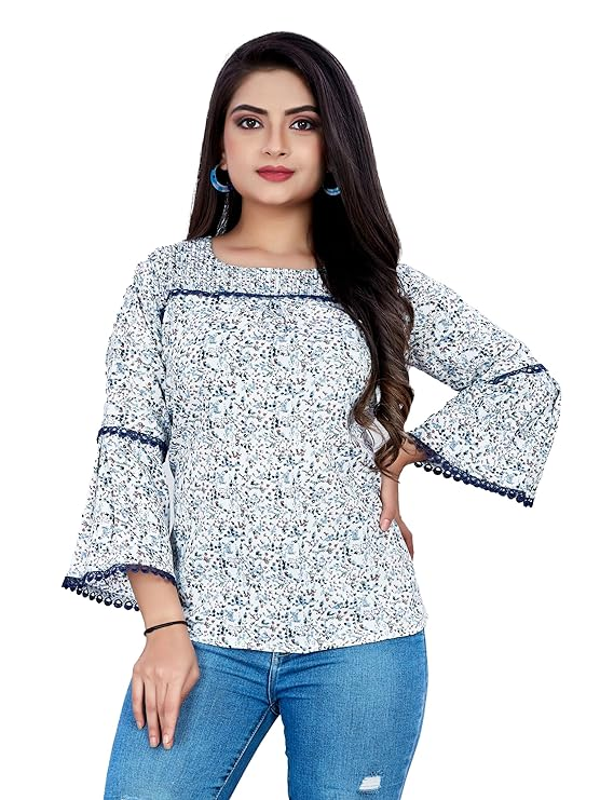

In [11]:
image = Image.open(open(IMAGE_PATH, "rb"))
image = fix_channels(ToTensor()(image))
image = image.resize((600, 800))
image

Photo by <a href="https://unsplash.com/@reza_delkhosh_?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Reza Delkhosh</a> on <a href="https://unsplash.com/photos/iRAOJYtPHZE?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>


In [12]:
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

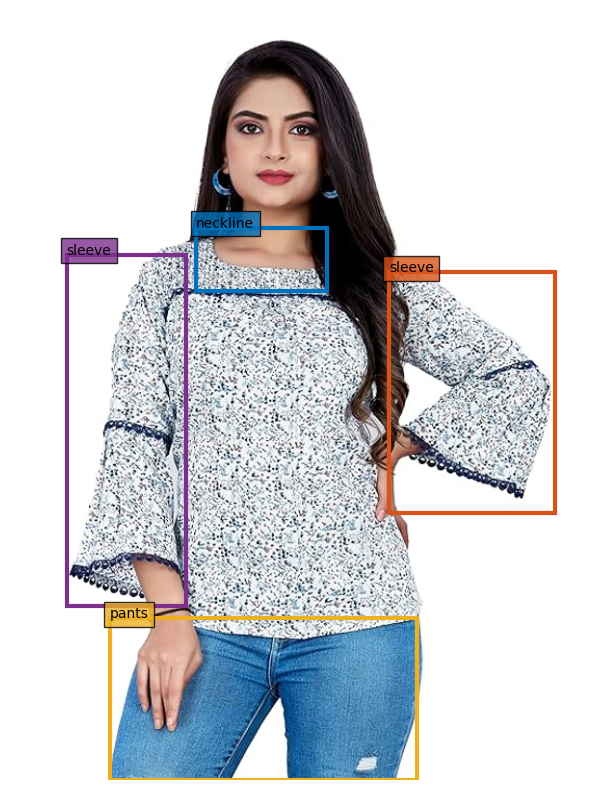

<Figure size 640x480 with 0 Axes>

In [13]:
img = visualize_predictions(image, outputs, threshold=0.5)
img

In [14]:
desired_category_index = cats.index('neckline')  # Replace 'your_desired_category' with the desired category





# Make predictions
with torch.no_grad():
    outputs = model(**inputs)



#

In [16]:
# Filter predictions for the desired category
threshold = 0.5

pred_logits = outputs.logits[0]
keep = (pred_logits[:, desired_category_index].softmax(dim=-1) > threshold)
pred_boxes = outputs.pred_boxes[0][keep].cpu()

pred_boxes

tensor([[0.4345, 0.3234, 0.2260, 0.0828]])

Average Height of Bounding Box: 0.2260
Average Width of Bounding Box: 0.0828


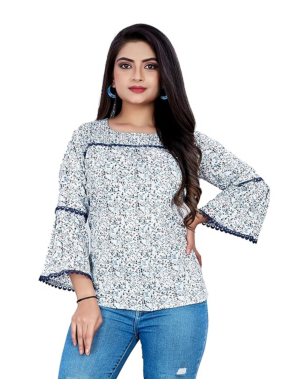

In [17]:
# Extract bounding boxes and calculate height and width
heights = pred_boxes[:, 2]
widths = pred_boxes[:, 3]

# Calculate the average height and width
average_height = heights.mean().item()
average_width = widths.mean().item()

# Print the results
print(f"Average Height of Bounding Box: {average_height:.4f}")
print(f"Average Width of Bounding Box: {average_width:.4f}")

# Plot the results
plt.imshow(image)
plt.axis('off')
plt.show()

In [18]:
from PIL import Image

# Open the image
image = Image.open(IMAGE_PATH)

# Get the dimensions of the image
width, height = image.size

# Print the dimensions
print(f"Width: {width} pixels")
print(f"Height: {height} pixels")

AREA_OF_IMAGE = width *height

Width: 556 pixels
Height: 741 pixels


In [19]:
average_height_pixels = average_height * height
average_width_pixels = average_width * width

print(f"Average Height of Bounding Box: {average_height_pixels:.2f} pixels")
print(f"Average Width of Bounding Box: {average_width_pixels:.2f} pixels")

Average Height of Bounding Box: 167.45 pixels
Average Width of Bounding Box: 46.01 pixels


In [20]:
AREA_OF_BB = average_height_pixels * average_width_pixels
AREA_OF_IMAGE = AREA_OF_IMAGE = width *height
RATIO = (AREA_OF_BB / AREA_OF_IMAGE ) * 100
RATIO

1.8700985927798008